##CSE 510: Building Reinforcement Learning Environment


> Anurag Saykar <br>
> email - anuragan@buffalo.edu <br>
> UBID - 50286920



# Installs and Imports

In [0]:
!pip install gym

In [0]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random
import time
from google.colab import widgets
from matplotlib import colors

import pandas as pd

In [2]:
output_grid = widgets.Grid(1, 1)

""


#RL Environments

The environment is essentially the world with which the agent interacts.  

![alt text](https://skymind.ai/images/wiki/simple_RL_schema.png)

*Image from the RL Book by Sutton

We can think of an environment as a (blackbox) function that takes in the current state and action and return the next state and reward.

Theoritically speaking, it is enough for the agent to be able to interact with environment.

However, from a implementation point of view an environment should not only allow the agent to take a particular action and recieve some reward, but also reset (i.e provide a start state at the beginning of an episode) itself.

From training standpoint it is also important to have a rendering mechanism for easier debugging.

# Setting Up the Environment


## Part 1 - Building a deterministic environment

In [0]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self, stochastic=0.0):
        self.observation_space = spaces.Box(low=0, high=0, shape=(5,5), dtype=np.int32)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 30
        
        self.jerry = plt.imread('jerry.jpg', format='jpg')
        self.tom = plt.imread('tom.png', format='png')
        self.cheese = plt.imread('cheese.jpg', format='jpg')
        self.trap = plt.imread('mouse_trap.jpg', format='jpg')
        self.goal = plt.imread('goal.jpg', format='jpg')
        self.p = stochastic
    
    def make_environment(self, obs_space):
        size = obs_space.size
        n_cheese = [1 for c in range(size//5)]
        n_obstacles = [2 for o in range(size//10)]
        n_empty = size - size//5 - size//10 - 3
        jerry, tom, goal = 0.5, 3, 4
        tmp_space = [0 for e in range(n_empty)] + [0, 0, 0] + n_cheese + n_obstacles
        obs_space = np.array(tmp_space, dtype=np.float32).reshape((5,5))
        #print (obs_space)
        np.random.seed(42)
        np.random.shuffle(obs_space.flat)
        obs_space[0, 0] = 0.5
        obs_space[4, 2] = 3
        obs_space[4, 4] = 4
        #print (obs_space)
        return obs_space
        
    def reset(self):
        self.timestep = 0
        tmp_state = self.observation_space.sample()
        self.space = self.make_environment(tmp_state)
        goal = np.where(self.space == 4.0)
        self.goal_pos = [goal[0][0], goal[1][0]]
        agent = np.where(self.space == 0.5)
        #print (agent)
        self.agent_pos = [agent[0][0], agent[1][0]]
        self.obs_sample = self.space.flatten()
        state = self.agent_pos[0] * 5 + self.agent_pos[1]
        return state
    
    def step(self, action):
        #self.state = np.random.choice(self.observation_space.n)
        old_pos = self.agent_pos.copy()
        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        
        #print ('old_pos', old_pos, 'agent_pos', self.agent_pos, 'action', action)
        
        reward = 0
        done = False
        
        #update the observation space
        self.space[tuple(old_pos)] = 0.0
        
        #make the environment stochastic
        p = np.random.choice(2, p=[self.p, 1 - self.p])
        if p == 0:
          self.space[tuple(old_pos)] = 0.5
          self.agent_pos = old_pos
        
        if self.space[tuple(self.agent_pos)] == 0:
          self.space[tuple(self.agent_pos)] = 0.5
        if self.space[tuple(self.agent_pos)] == 1:
          self.space[tuple(self.agent_pos)] = 0.5
          reward += 10 #found cheese!
        if self.space[tuple(self.agent_pos)] == 2:
          self.space[tuple(old_pos)] = 0.5
          self.agent_pos = old_pos
          reward -= 10
        if self.space[tuple(self.agent_pos)] == 3:
          reward -= 100
          #print ('should start new episode')
          done = True
        if self.space[tuple(self.agent_pos)] == 4:
          reward += 100
          done = True
        
        self.obs_sample = self.space.flatten()
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps:
          done = True 
        info = {}
        
        state = self.agent_pos[0] * 5 + self.agent_pos[1]
        
        return state, reward, done, info
    
    def render_objects(self, val, img):
        locs = np.where(self.space == val)
        for x, y in zip(locs[0], locs[1]):
          plt.imshow(img, extent=[x - 0.5, x + 0.5, y - 0.5, y + 0.5])

    def render(self):
        cmap = colors.ListedColormap(['white'])
        plt.imshow(self.space, cmap=cmap)
        self.render_objects(1, self.cheese)
        self.render_objects(2, self.trap)
        self.render_objects(0.5, self.jerry)
        self.render_objects(3, self.tom)
        self.render_objects(4, self.goal)
        plt.plot()

## The Big Picture:



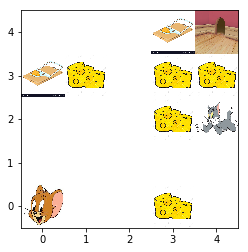

In [5]:
env = GridEnvironment()
obs = env.reset()
env.render()

Here we're defining a 5x5 grid world representing a Tom & Jerry Game.  

Jerry can move one tile at a time. The goal is to get home (4, 4) as quickly as possible. 

---
This can be evaluated using a scoring system as follows:



*   -1 point at each step (helps agent to be fast).
*   If Jerry runs into Tom, -100 points and the episode ends.
*   -10 points if Jerry runs into Traps.
*   +10 points for cheese.
*   +100 points if Jerry reaches home and the episode ends.



All element are static i.e P(s′, r|s, a) ={0,1}. In other words, the agent can deterministically move (or not!) in a location should he choose to.

The transition probability matrix for the above deterministic environment would be a 25x25 matrix.

Consider an example of a 2x2 grid world for easier visualization. The transition matrix for a deterministic gridworld would look as follows:

In [8]:
grid = np.array([[0,1], [2,3]])
print ('Grid World')
print (grid)
transition_matrix = np.eye(grid.size) * 0.5
transition_matrix[0, 1], transition_matrix[0, 2] = 0.25, 0.25

transition_matrix[1, 0], transition_matrix[1, 3] = 0.25, 0.25

transition_matrix[2, 0], transition_matrix[2, 3] = 0.25, 0.25

transition_matrix[3, 1], transition_matrix[3, 2] = 0.25, 0.25

transition_df = pd.DataFrame(transition_matrix, columns=[0,1,2,3])

transition_df

Grid World
[[0 1]
 [2 3]]


,0,1,2,3
0,0.50,0.25,0.25,0.00
1,0.25,0.50,0.00,0.25
2,0.25,0.00,0.50,0.25
3,0.00,0.25,0.25,0.50


<h5>*The above table assumes that every action (left, right, up and down) is equally probable.</h5>

The rows represent start state and the columns show the end state, with each cell value being the probability the that particular transition.

The 0's represent invalid moves (i.e since the agent cannot move diagonally, it cannot go from state 0 to state 3 directly).

At the edge of the grid (eg. state 0), certain actions (up and left) end up with the agent in the same state.

Since the values are probabilities, they (should) sum up to 1. The **transition matrix allows** us a complete **overview of the agent's environment** and such the agent itself does not need to reference the matrix directly.

##Part 2 - Building a stochastic environment

In a deterministic environment next state s' is determined by the agent's current state and/or action alone. i.e there is absolutely no uncertainty or more precisely, all *uncertainty is* ***ignored***.

In stochastic environments, there is always an element of randomness, either with the environment or the policy . 

The Tom & Jerry environment can be made stochastic in various ways, by allowing Tom to move, or even randomizing the start location of the agent. 

For the sake of simplicity, we'll add a small chance ~4% that Jerry may slip while moving and stay in the same state.

This would result in the following transition matrix: 

In [9]:
grid = np.array([[0,1], [2,3]])
print ('Grid World')
print (grid)
transition_matrix = np.eye(grid.size) * 0.52
transition_matrix[0, 1], transition_matrix[0, 2] = 0.24, 0.24

transition_matrix[1, 0], transition_matrix[1, 3] = 0.24, 0.24

transition_matrix[2, 0], transition_matrix[2, 3] = 0.24, 0.24

transition_matrix[3, 1], transition_matrix[3, 2] = 0.24, 0.24

transition_df = pd.DataFrame(transition_matrix, columns=[0,1,2,3])

transition_df

Grid World
[[0 1]
 [2 3]]


,0,1,2,3
0,0.52,0.24,0.24,0.00
1,0.24,0.52,0.00,0.24
2,0.24,0.00,0.52,0.24
3,0.00,0.24,0.24,0.52


This can be explained as follows:

For state 0: 4% probability to stay in the same state, which gives the neighbouring states the probability of 24% each, and since the top and left neighbour of state 0 is state 0 itself, the transition probability is .24 + .24 + .04 = .52

# The Q(uality of Action)-Table


Strategy: create a table where we’ll calculate the maximum expected future reward, for each action at each state.

The agent uses the Q Table as a cheat sheet, to navigate the environment. 

![alt text](https://cdn-images-1.medium.com/max/800/1*kwu9TImqAWZCiooj3pLyCA.png)


*But how will we calculate the q-values!?*

## The Bellman Equation

![alt text](https://cdn-images-1.medium.com/max/2400/1*jmcVWHHbzCxDc-irBy9JTw.png)

# The Q Learning Algorithm

![alt text](https://cdn-images-1.medium.com/max/800/1*QeoQEqWYYPs1P8yUwyaJVQ.png)

*Image Credits: Thomas Simonini

In [0]:
class Q_Agent:
  def __init__(self, env, learning_rate, gamma):
    self.env = env
    self.observation_space = env.space
    self.action_space = env.action_space
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.q_table = np.zeros((self.observation_space.size, self.action_space.n))
  
  def step(self, state, tradeoff, epsilon):
    # Exploit (the biggest Q value for this state)
    if tradeoff > epsilon:
      action = np.argmax(self.q_table[state,:])
    # Else doing a random choice --> exploration
    else:
      action = self.action_space.sample()
    return action
  
  def update(self, state, action, new_state, reward):
    self.q_table[state, action] = self.q_table[state, action] + self.learning_rate * (reward + self.gamma * np.max(self.q_table[new_state, :]) - self.q_table[state, action]) 

### But…what action can we take in the beginning, if every Q-value equals zero?

## The Exploration/Exploitation trade-off

* We specify an exploration rate “epsilon,” which we set to 1 in the beginning. This is the rate of steps that we’ll do randomly. In the beginning, this rate must be at its highest value, because we don’t know anything about the values in Q-table. This means we need to do a lot of exploration, by randomly choosing our actions.

* We generate a random number. If this number > epsilon, then we will do “exploitation” (this means we use what we already know to select the best action at each step). Else, we’ll do exploration.

* The idea is that we must have a big epsilon at the beginning of the training of the Q-function. Then, reduce it progressively as the agent becomes more confident at estimating Q-values.

![alt text](https://cdn-images-1.medium.com/max/800/1*9StLEbor62FUDSoRwxyJrg.png)

#Training & Results

##Deterministic Environment

In [0]:
env = GridEnvironment()
env.reset()

q_agent = Q_Agent(env, learning_rate=0.95, gamma=0.96)

total_episodes = 3500

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005             # Exponential decay rate for exploration prob

In [25]:
rewards = []
epsilons = []

for episode in range(total_episodes):
  state = env.reset()
  
  total_rewards = 0
  
  done = False
  if episode % 500 == 0:
    print ('Episode No:', episode)
  while not done:
    tradeoff = random.uniform(0, 1)
    action = q_agent.step(state, tradeoff, epsilon)
    new_state, reward, done, info = q_agent.env.step(action)
    
    reward -= 1
    
    #similar to stochastic gradient descent
    q_agent.update(state, action, new_state, reward)
    
    total_rewards += reward
    
    state = new_state
    #rendering mades the training very slow
    #with output_grid.output_to(0, 0):
    #  output_grid.clear_cell()
    #  env.render()
    #time.sleep(1)

  epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
  epsilons.append(epsilon)
  rewards.append(total_rewards)

Episode No: 0
Episode No: 500
Episode No: 1000
Episode No: 1500
Episode No: 2000
Episode No: 2500
Episode No: 3000


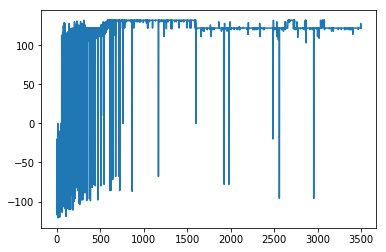

In [26]:
# Everything is a hyper parameter!
plt.plot(rewards)

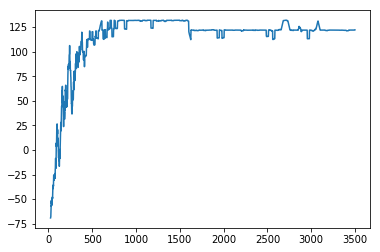

In [27]:
#moving average makes it easier to see the trend
df = pd.DataFrame(rewards, columns=['r'])
rolling_mean = df['r'].rolling(window=25).mean()
plt.plot(rolling_mean)

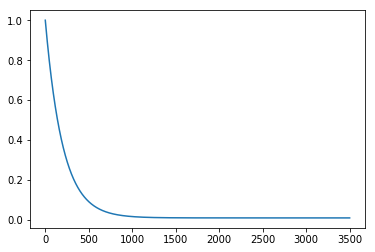

In [15]:
plt.plot(epsilons)

In [28]:
# the states are numbered vertically, bottom up
# action indices 0, 1, 2, 3 correspond to right, left, up ,down
# agent chooses the action with max q value for that particular state
q_df = pd.DataFrame(q_agent.q_table, columns=['right', 'left', 'up' ,'down'])
q_df

,right,left,up,down
0,93.008152,83.634366,86.660398,83.430065
1,97.474367,79.421554,79.708487,79.726882
2,83.462312,79.520131,73.329885,83.153209
3,0.000000,0.000000,0.000000,0.000000
4,84.074506,61.616296,61.636615,76.696311
5,87.919404,73.830764,97.925158,87.561074
6,91.138729,91.074453,103.047040,92.590326
7,83.740041,82.671820,108.382333,87.646795
8,103.523264,73.904881,84.996803,85.266742
9,82.650444,82.144704,84.162539,83.476580


### Let's Play!

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

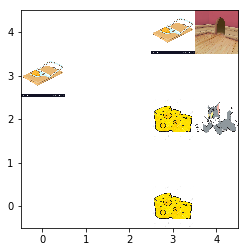

<IPython.core.display.Javascript object>

In [29]:
for episode in range(2):
  state = env.reset()
  
  total_reward = 0
  
  done = False
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    env.render()
  time.sleep(0.25)
  while not done:
    action = q_agent.step(state, tradeoff, epsilon)
    new_state, reward, done, info = q_agent.env.step(action)
    reward -= 1
    
    total_reward += reward
    with output_grid.output_to(0, 0):
      output_grid.clear_cell()
      env.render()
    time.sleep(0.25)
    state = new_state
    
  #print (episode, total_reward)
    
    
  

##Stochastic Environment

In [0]:
env = GridEnvironment(stochastic=0.04)
env.reset()

q_agent = Q_Agent(env, learning_rate=0.95, gamma=0.96)

total_episodes = 3500

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005             # Exponential decay rate for exploration prob

In [19]:
rewards = []
epsilons = []

for episode in range(total_episodes):
  state = env.reset()
  
  total_rewards = 0
  
  done = False
  if episode % 500 == 0:
    print ('Episode No:', episode)
  while not done:
    tradeoff = random.uniform(0, 1)
    action = q_agent.step(state, tradeoff, epsilon)
    new_state, reward, done, info = q_agent.env.step(action)
    
    reward -= 1
    
    #similar to stochastic gradient descent
    q_agent.update(state, action, new_state, reward)
    
    total_rewards += reward
    
    state = new_state
    #rendering mades the training very slow
    #with output_grid.output_to(0, 0):
    #  output_grid.clear_cell()
    #  env.render()
    #time.sleep(1)

  epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
  epsilons.append(epsilon)
  rewards.append(total_rewards)

Episode No: 0
Episode No: 500
Episode No: 1000
Episode No: 1500
Episode No: 2000
Episode No: 2500
Episode No: 3000


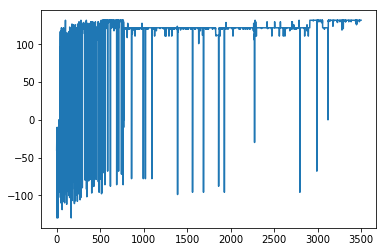

In [20]:
plt.plot(rewards)

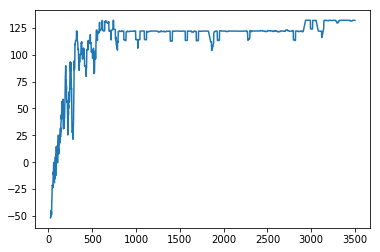

In [21]:
df = pd.DataFrame(rewards, columns=['r'])
rolling_mean = df['r'].rolling(window=25).mean()
plt.plot(rolling_mean)

In [22]:
q_df = pd.DataFrame(q_agent.q_table, columns=['right', 'left', 'up' ,'down'])
q_df

,right,left,up,down
0,101.870258,95.893741,79.880060,79.290896
1,79.950281,79.902845,80.189560,83.408971
2,86.176336,83.798539,73.761127,84.247495
3,0.000000,0.000000,0.000000,0.000000
4,80.115886,82.032698,80.215058,74.979592
5,107.156518,79.535596,79.644170,79.831224
6,83.419100,82.685010,83.521278,77.533874
7,98.356324,80.763186,88.810936,88.263921
8,92.877892,88.381813,84.028956,91.644780
9,82.653637,80.214657,83.994237,88.481100


### Let's Play!

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

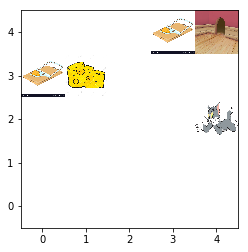

<IPython.core.display.Javascript object>

In [23]:
for episode in range(2):
  state = env.reset()
  
  total_reward = 0
  
  done = False
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    env.render()
  time.sleep(0.25)
  while not done:
    action = q_agent.step(state, tradeoff, epsilon)
    new_state, reward, done, info = q_agent.env.step(action)
    reward -= 1
    
    total_reward += reward
    with output_grid.output_to(0, 0):
      output_grid.clear_cell()
      env.render()
    time.sleep(0.25)
    state = new_state
    
  #print (episode, total_reward)

#Conclusions

More stochastic the environment is, the harder it is for the agent to learn.

In this case the agent performs relatively well when the randomness (chance of slipping) in the environment is small (< 0.1), and it get harder as the p increased to 0.15. After that, the agent is simply unable to learn.   